In [89]:
# import neessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from matplotlib.colors import LinearSegmentedColormap
import pickle
import warnings
import os

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [90]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [91]:
pd.set_option('display.max_columns', 20)

In [92]:
def percent_removed(original_df, cleaned_df):
    percentage = round((len(original_df)/len(cleaned_df)-1)*100,2)
    return percentage

In [93]:
df_satellite_to_append = []
df_solar_to_append = []

# Load and append data for each farm
for farm in [1, 2, 3, 4, 5]:
    satellite_to_append = pd.read_csv(f"../data/solar/enlitia_satellite_{farm}_data.csv")
    df_satellite_to_append.append(satellite_to_append)
    
    solar_to_append = pd.read_csv(f"../data/solar/enlitia_solar_farm_{farm}_data.csv")
    solar_to_append['farm'] = farm  # Add a 'farm' column with the farm number
    df_solar_to_append.append(solar_to_append)

# Concatenate the DataFrames and reset index
df_satellite = pd.concat(df_satellite_to_append, ignore_index=True)
df_solar = pd.concat(df_solar_to_append, ignore_index=True)

print("Satellite DataFrame:\n", df_satellite.head(),"\n")
print("Solar DataFrame:\n", df_solar.head(),"\n")

Satellite DataFrame:
    satellite_id              read_at  global_tilted_irradiance  \
0             1  2022-01-01 00:00:00                       0.0   
1             1  2022-01-01 00:10:00                       0.0   
2             1  2022-01-01 00:20:00                       0.0   
3             1  2022-01-01 00:30:00                       0.0   
4             1  2022-01-01 00:40:00                       0.0   

   global_horizontal_irradiance  temperature  cloud_cover  
0                           0.0         13.0          1.4  
1                           0.0         12.9          2.8  
2                           0.0         12.9          2.8  
3                           0.0         12.9          1.4  
4                           0.0         12.8          6.6   

Solar DataFrame:
    asset_id              read_at  ac_power  ac_voltage  ac_current   dc_power  \
0        11  2022-01-01 07:40:00       0.0         4.0       0.000    0.00000   
1        11  2022-01-01 07:50:00       

In [94]:
dfs_dict_solar = {
    "Satellite" : df_satellite,
    "Solar": df_solar,
}

for key, value in dfs_dict_solar.items():
    print(f"Information of {key} df")
    print(value.info(),"\n")

with open("intermediate/solar/dfs_dict_solar.pickle", "wb") as f:
    pickle.dump(dfs_dict_solar, f)

Information of Satellite df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476012 entries, 0 to 476011
Data columns (total 6 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   satellite_id                  476012 non-null  int64  
 1   read_at                       476012 non-null  object 
 2   global_tilted_irradiance      476012 non-null  float64
 3   global_horizontal_irradiance  476012 non-null  float64
 4   temperature                   476012 non-null  float64
 5   cloud_cover                   476012 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 21.8+ MB
None 

Information of Solar df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4081774 entries, 0 to 4081773
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   asset_id    int64  
 1   read_at     object 
 2   ac_power    float64
 3   ac_voltage  float64
 4   ac_current  float64
 

In [95]:
df_satellite_copy = df_satellite.copy(deep=True)

df_satellite_copy.rename(columns={'satellite_id': 'farm'}, inplace=True)

merged_df_raw = df_solar.merge(df_satellite_copy, on=["read_at", "farm"], how="inner")

merged_df_raw.to_csv("intermediate/solar/solar_satellite_merged_raw.csv", index=False)

In [96]:
with open("intermediate/solar/dfs_dict_solar.pickle", "rb") as f:
    dfs_dict_solar = pickle.load(f)

df_solar = dfs_dict_solar["Solar"]
df_satellite = dfs_dict_solar["Satellite"]

In [97]:
for key, value in dfs_dict_solar.items():
    print(f"Shape of {key} df: \n {value.shape} \n")

Shape of Satellite df: 
 (476012, 6) 

Shape of Solar df: 
 (4081774, 9) 



In [98]:
for key, value in dfs_dict_solar.items():
    print(f"Head of {key} df: \n {value.head()} \n")
    print(f"Tail of {key} df: \n {value.tail()} \n")

Head of Satellite df: 
    satellite_id              read_at  global_tilted_irradiance  \
0             1  2022-01-01 00:00:00                       0.0   
1             1  2022-01-01 00:10:00                       0.0   
2             1  2022-01-01 00:20:00                       0.0   
3             1  2022-01-01 00:30:00                       0.0   
4             1  2022-01-01 00:40:00                       0.0   

   global_horizontal_irradiance  temperature  cloud_cover  
0                           0.0         13.0          1.4  
1                           0.0         12.9          2.8  
2                           0.0         12.9          2.8  
3                           0.0         12.9          1.4  
4                           0.0         12.8          6.6   

Tail of Satellite df: 
         satellite_id              read_at  global_tilted_irradiance  \
476007             5  2024-01-09 14:00:00                     119.0   
476008             5  2024-01-09 14:10:00          

In [99]:
print(f"Number of assets for Solar df: {df_solar['asset_id'].nunique()} \n")

print(f"Number of assets for Satellite df: {df_satellite['satellite_id'].nunique()} \n")


Number of assets for Solar df: 77 

Number of assets for Satellite df: 5 



In [100]:
for key, value in dfs_dict_solar.items():
    print(f"Description for {key} df: \n {value.describe()} \n")

Description for Satellite df: 
         satellite_id  global_tilted_irradiance  global_horizontal_irradiance  \
count  476012.000000             476012.000000                 476012.000000   
mean        2.955094                209.564561                    183.423351   
std         1.397527                312.788216                    271.583113   
min         1.000000                  0.000000                      0.000000   
25%         2.000000                  0.000000                      0.000000   
50%         3.000000                  0.000000                      0.000000   
75%         4.000000                348.000000                    311.000000   
max         5.000000               1113.000000                   1022.000000   

         temperature    cloud_cover  
count  476012.000000  476012.000000  
mean       15.583318      24.080120  
std         5.670874      28.409902  
min        -2.000000       0.000000  
25%        12.000000       0.000000  
50%        15.00000

Description for Solar df: 
            asset_id      ac_power    ac_voltage    ac_current      dc_power  \
count  4.081774e+06  4.081774e+06  3.982052e+06  3.982052e+06  4.081774e+06   
mean   1.418847e+02  8.250519e+03  2.233950e+02  1.176300e+01  8.343587e+03   
std    1.527319e+02  1.636367e+04  5.001457e+01  2.296747e+01  1.676218e+04   
min    1.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00 -8.559200e+02   
25%    2.900000e+01  5.120000e+02  2.310000e+02  1.013000e+00  5.063930e+02   
50%    5.100000e+01  3.273000e+03  2.340000e+02  4.679000e+00  3.173520e+03   
75%    2.170000e+02  8.505000e+03  2.380000e+02  1.204300e+01  8.544120e+03   
max    5.140000e+02  1.100000e+05  2.536330e+02  1.589280e+02  1.153130e+05   

         dc_voltage    dc_current          farm  
count  4.081774e+06  4.081774e+06  4.081774e+06  
mean   4.689956e+02  7.561604e+00  2.943689e+00  
std    1.049270e+02  8.301691e+00  1.314537e+00  
min    0.000000e+00 -5.500000e-02  1.000000e+00  
25%    4.5

In [101]:
for key, value in dfs_dict_solar.items():
    print(f"NAs count for {key}")
    print(value.isna().sum(), "\n")

NAs count for Satellite
satellite_id                    0
read_at                         0
global_tilted_irradiance        0
global_horizontal_irradiance    0
temperature                     0
cloud_cover                     0
dtype: int64 

NAs count for Solar
asset_id          0
read_at           0
ac_power          0
ac_voltage    99722
ac_current    99722
dc_power          0
dc_voltage        0
dc_current        0
farm              0
dtype: int64 



### Check Nulls

In [102]:
df_solar_only_na = df_solar[df_solar["ac_voltage"].isna()]
print(df_solar_only_na)

         asset_id              read_at  ac_power  ac_voltage  ac_current  \
3109038       411  2022-01-01 07:40:00       0.0         NaN         NaN   
3109039       411  2022-01-01 07:50:00       0.0         NaN         NaN   
3109040       411  2022-01-01 08:00:00       0.0         NaN         NaN   
3109041       411  2022-01-01 08:10:00     259.0         NaN         NaN   
3109042       411  2022-01-01 08:20:00     531.0         NaN         NaN   
...           ...                  ...       ...         ...         ...   
3208755       412  2024-01-09 13:20:00    1857.0         NaN         NaN   
3208756       412  2024-01-09 13:30:00    2015.0         NaN         NaN   
3208757       412  2024-01-09 13:40:00    2114.0         NaN         NaN   
3208758       412  2024-01-09 13:50:00    1459.0         NaN         NaN   
3208759       412  2024-01-09 14:00:00    4352.0         NaN         NaN   

         dc_power  dc_voltage  dc_current  farm  
3109038       0.0      482.74       0

In [103]:
df_solar_only_na["asset_id"].unique()

array([411, 412])

In [104]:
print(f"All rows for asset 411: {df_solar[df_solar['asset_id']==411].shape[0]}")
print(f"All rows for asset 412: {df_solar[df_solar['asset_id']==412].shape[0]}\n")
print(f"Null rows for asset 411: {df_solar_only_na[df_solar_only_na['asset_id']==411].shape[0]}")
print(f"Null rows for asset 412: {df_solar_only_na[df_solar_only_na['asset_id']==412].shape[0]}")

All rows for asset 411: 49925
All rows for asset 412: 49797

Null rows for asset 411: 49925
Null rows for asset 412: 49797


So, all rows for assets 411 and 412 have NAs in the cols ac_current and ac_voltage

#### Fill NAs

AC power = AC current * AC voltage

ac_voltage < 220 and NAs = 230 as is the common voltage in Europe, assuming short-circuits not happening in the period in analysis

ac_current = ac_power/ac_voltage

In [105]:
df_solar.loc[(df_solar["ac_voltage"] < 220) | df_solar["ac_voltage"].isna(), "ac_voltage"] = 230
df_solar.loc[df_solar["ac_current"].isna(), "ac_current"] = df_solar.loc[df_solar["ac_current"].isna(), "ac_power"]/df_solar.loc[df_solar["ac_current"].isna(), 
                                                                                                                                 "ac_voltage"]
df_solar[(df_solar["asset_id"]==411) | (df_solar["asset_id"]==412)]

asset_id              read_at  ac_power  ac_voltage  ac_current  \
3109038       411  2022-01-01 07:40:00       0.0       230.0    0.000000   
3109039       411  2022-01-01 07:50:00       0.0       230.0    0.000000   
3109040       411  2022-01-01 08:00:00       0.0       230.0    0.000000   
3109041       411  2022-01-01 08:10:00     259.0       230.0    1.126087   
3109042       411  2022-01-01 08:20:00     531.0       230.0    2.308696   
...           ...                  ...       ...         ...         ...   
3208755       412  2024-01-09 13:20:00    1857.0       230.0    8.073913   
3208756       412  2024-01-09 13:30:00    2015.0       230.0    8.760870   
3208757       412  2024-01-09 13:40:00    2114.0       230.0    9.191304   
3208758       412  2024-01-09 13:50:00    1459.0       230.0    6.343478   
3208759       412  2024-01-09 14:00:00    4352.0       230.0   18.921739   

         dc_power  dc_voltage  dc_current  farm  
3109038       0.0      482.74       0.000     4  
3109039       0.0      519.87       0.000     4  
3109040       0.0      527.25       0.000     4  
3109041     188.0      456.33       0.419     4  
3109042     349.0      479.84       0.733     4  
...           ...         ...         ...   ...  
3208755    1877.0      518.82       3.621     4  
3208756    2047.0      537.71       3.808     4  
3208757    2136.0      543.88       3.929     4  
3208758    1465.0      511.86       2.864     4  
3208759    4438.0      521.15       8.518     4  

[99722 rows x 9 columns]

### Check duplicated rows

In [106]:
for key, value in dfs_dict_solar.items():
    print(f"Duplicated values for the {key} df: {value[value.duplicated()]}")

Duplicated values for the Satellite df: Empty DataFrame
Columns: [satellite_id, read_at, global_tilted_irradiance, global_horizontal_irradiance, temperature, cloud_cover]
Index: []
Duplicated values for the Solar df: Empty DataFrame
Columns: [asset_id, read_at, ac_power, ac_voltage, ac_current, dc_power, dc_voltage, dc_current, farm]
Index: []


In [107]:
filtered_dfs_dict_solar = {}

for key, df in dfs_dict_solar.items():
    filtered_df = df.iloc[:, 2:-1]
    filtered_dfs_dict_solar[key] = filtered_df
    print(filtered_df)

with open(f"intermediate/solar/filtered_dfs_dict_solar.pickle", "wb") as f:
    pickle.dump(filtered_dfs_dict_solar, f)

        global_tilted_irradiance  global_horizontal_irradiance  temperature
0                            0.0                           0.0         13.0
1                            0.0                           0.0         12.9
2                            0.0                           0.0         12.9
3                            0.0                           0.0         12.9
4                            0.0                           0.0         12.8
...                          ...                           ...          ...
476007                     119.0                         124.0         12.0
476008                     121.0                         125.0         12.0
476009                      82.0                          85.0         12.0
476010                      49.0                          51.0         13.0
476011                      21.0                          22.0         13.0

[476012 rows x 3 columns]
         ac_power  ac_voltage  ac_current     dc_power  dc_vo

## Features distribution


Boxplots for the filtered Satellite df:


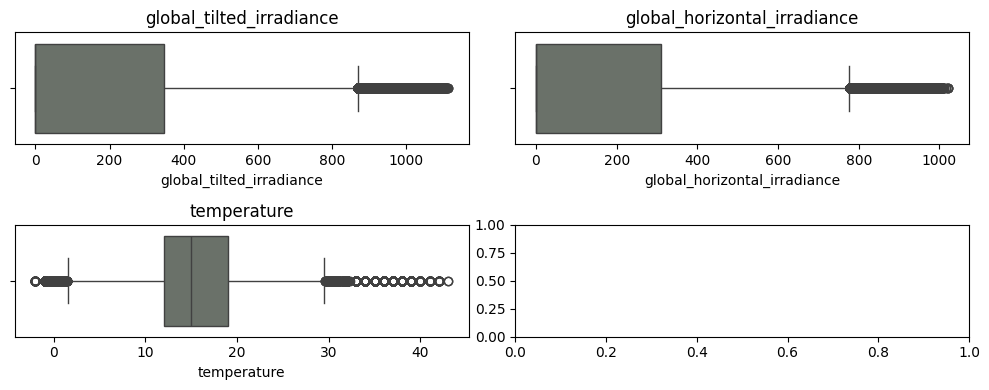


Boxplots for the filtered Solar df:


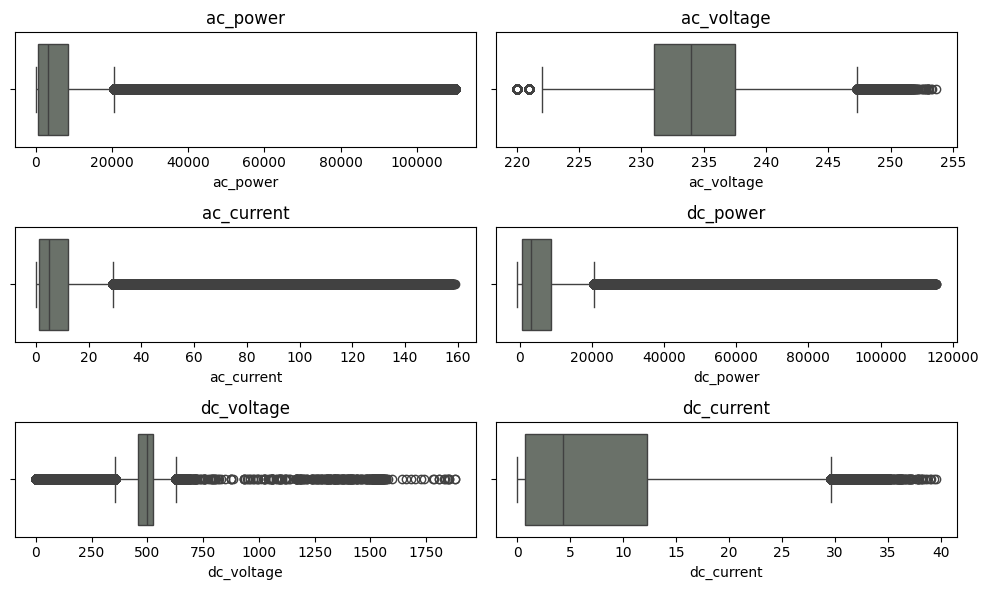

In [240]:

for key, value in filtered_dfs_dict_solar.items():
    print(f"\nBoxplots for the filtered {key} df:")
    num_cols = len(value.columns)
    num_rows = (num_cols + 1) // 2  
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows*2))

    axes = axes.flatten()
    
    for i, feature in enumerate(value.columns):
        if i < num_cols:  
            sns.boxplot(x=value[feature], color='#697268', ax=axes[i])
            axes[i].set_title(feature)  
    plt.tight_layout() 
    plt.show()


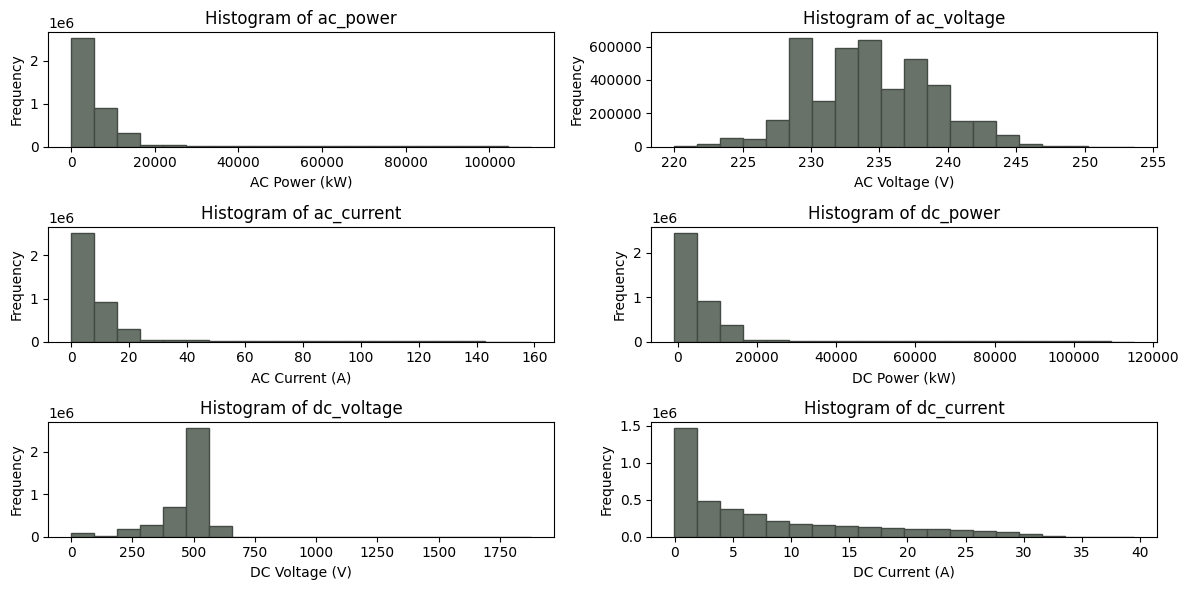

In [241]:
# Plotting the histograms
subset = df_solar.iloc[:, 2:-1]
column_names = ["AC Power (kW)", "AC Voltage (V)","AC Current (A)", "DC Power (kW)", "DC Voltage (V)","DC Current (A)"]

fig, axs = plt.subplots(int(len(column_names)/2), 2, figsize=(12, 6))  

for i, column in enumerate(subset.columns):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    axs[row_index, col_index].hist(subset[column], bins=20, color='#697268', edgecolor='#444a44') 
    axs[row_index, col_index].set_xlabel(column_names[i])
    axs[row_index, col_index].set_ylabel('Frequency')
    axs[row_index, col_index].set_title(f'Histogram of {column}')
    axs[row_index, col_index].grid(False)

plt.tight_layout()  
plt.show()

In [242]:
df_satellite.columns

Index(['satellite_id', 'read_at', 'global_tilted_irradiance',
       'global_horizontal_irradiance', 'temperature', 'cloud_cover'],
      dtype='object')

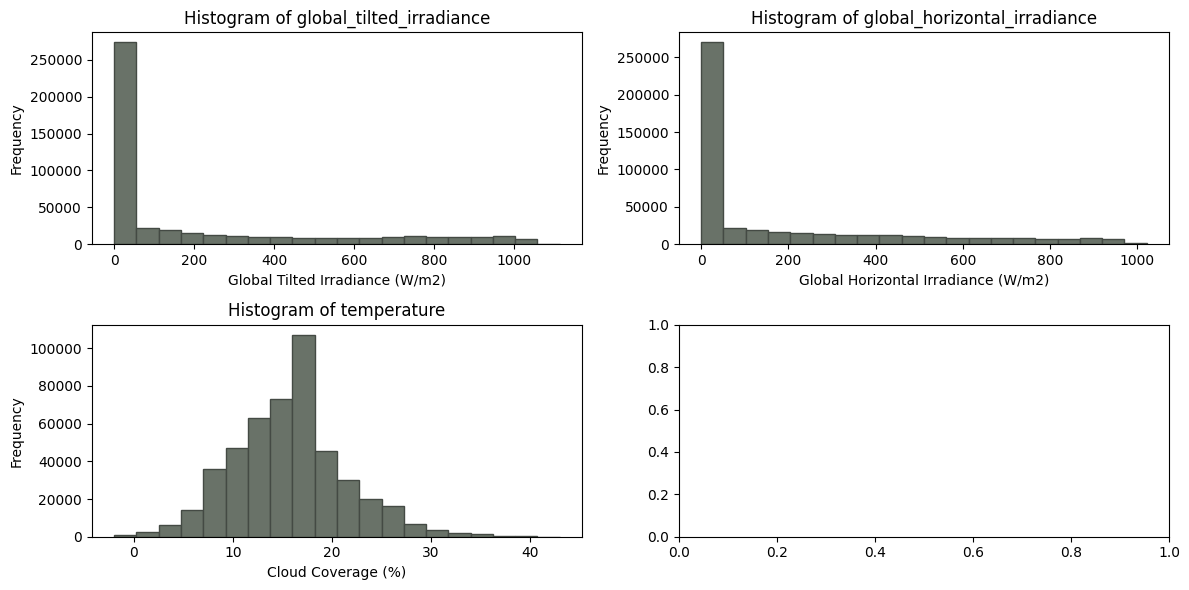

In [243]:
# Plotting the histograms
subset = df_satellite.iloc[:, 2:-1]
column_names = ["Global Tilted Irradiance (W/m2)", "Global Horizontal Irradiance (W/m2)","Cloud Coverage (%)", "Temperature (ºC)"]

num_rows = int(len(column_names)/2)

fig, axs = plt.subplots(num_rows, 2, figsize=(num_rows*6, 6))  

for i, column in enumerate(subset.columns):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    axs[row_index, col_index].hist(subset[column], bins=20, color='#697268', edgecolor='#444a44') 
    axs[row_index, col_index].set_xlabel(column_names[i])
    axs[row_index, col_index].set_ylabel('Frequency')
    axs[row_index, col_index].set_title(f'Histogram of {column}')
    axs[row_index, col_index].grid(False)

plt.tight_layout()  
plt.show()

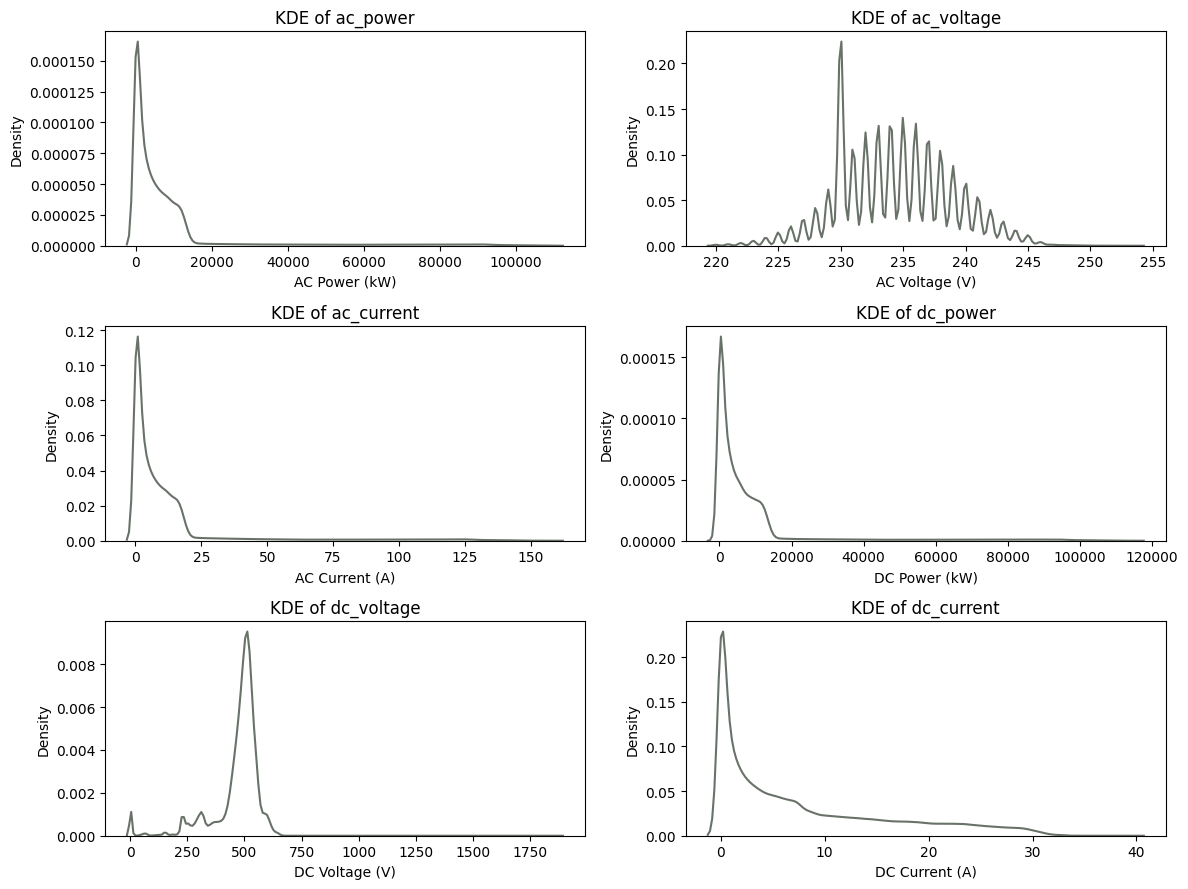

In [244]:
xlabels_names = ["AC Power (kW)", "AC Voltage (V)","AC Current (A)", "DC Power (kW)", "DC Voltage (V)","DC Current (A)"]
subset = df_solar.iloc[:, 2:-1]

num_rows = int(len(xlabels_names)/2)

fig, axs = plt.subplots(num_rows, 2, figsize=(num_rows*4, num_rows*3))

for i, column in enumerate(subset.columns):
    row_index = i // 2  
    col_index = i % 2  
    sns.kdeplot(subset[column], ax=axs[row_index, col_index], color='#697268')
    axs[row_index, col_index].set_xlabel(xlabels_names[i])
    axs[row_index, col_index].set_ylabel('Density')
    axs[row_index, col_index].set_title(f'KDE of {column}')
    axs[row_index, col_index].grid(False)

plt.tight_layout()
plt.show()


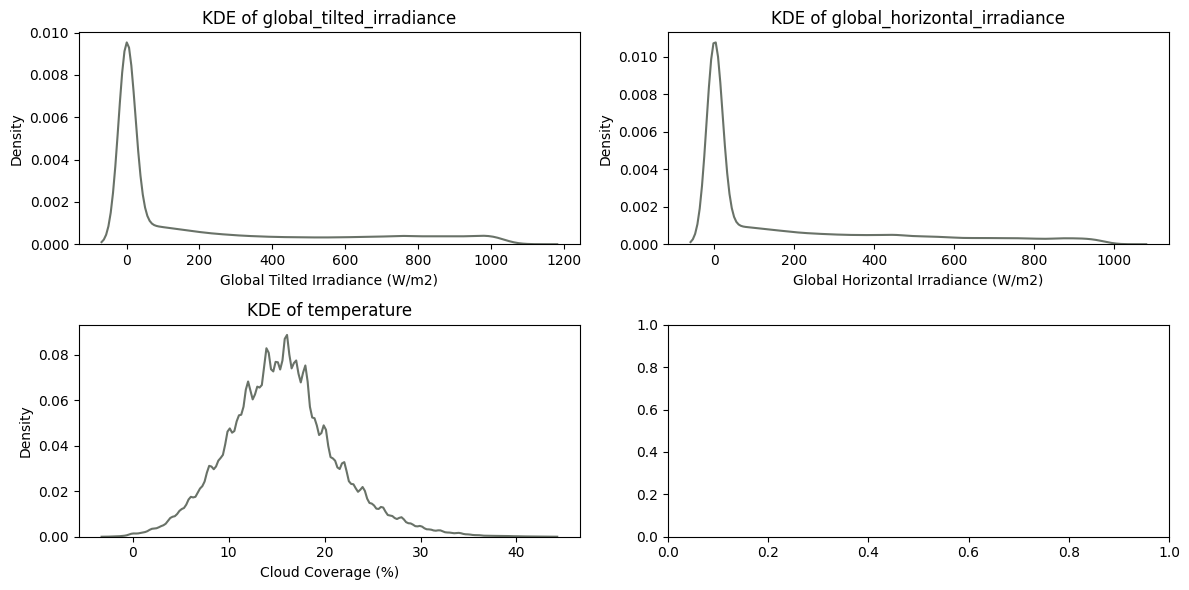

In [245]:
subset = df_satellite.iloc[:, 2:-1]
xlabels_names = ["Global Tilted Irradiance (W/m2)", "Global Horizontal Irradiance (W/m2)","Cloud Coverage (%)", "Temperature (ºC)"]

num_rows = int(len(xlabels_names)/2)

fig, axs = plt.subplots(num_rows, 2, figsize=(num_rows*6, num_rows*3))

for i, column in enumerate(subset.columns):
    row_index = i // 2  
    col_index = i % 2  
    sns.kdeplot(subset[column], ax=axs[row_index, col_index], color='#697268')
    axs[row_index, col_index].set_xlabel(xlabels_names[i])
    axs[row_index, col_index].set_ylabel('Density')
    axs[row_index, col_index].set_title(f'KDE of {column}')
    axs[row_index, col_index].grid(False)

plt.tight_layout()
plt.show()

## Feature relationships

In [246]:
xlabels_names = ["AC Power (kW)", "AC Voltage (V)","AC Current (A)", "DC Power (kW)", "DC Voltage (V)","DC Current (A)"]

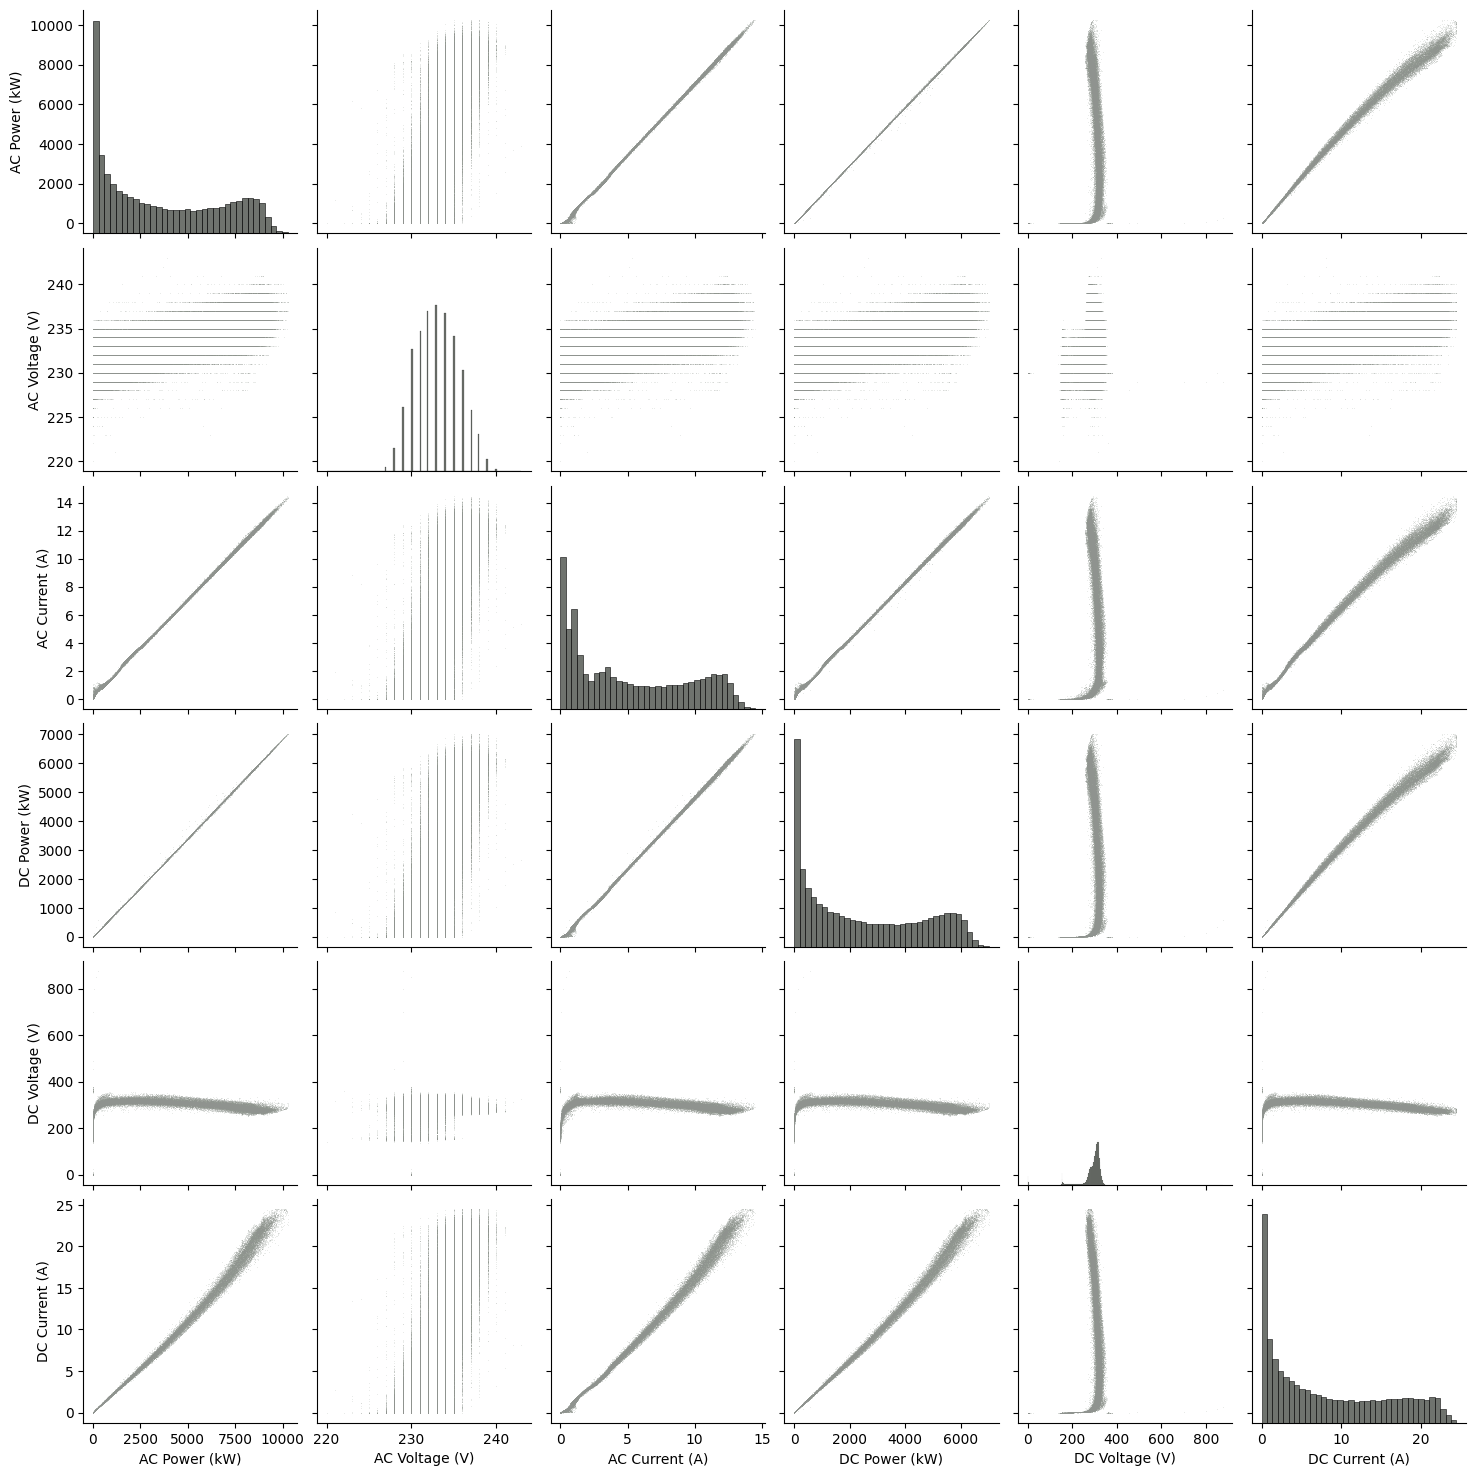

In [247]:
df_solar_pairplot = df_solar.copy()    

asset = df_solar_pairplot["asset_id"].unique()[:1]

subset = df_solar_pairplot[df_solar_pairplot["asset_id"].isin(asset)]
subset = subset.iloc[:,2:-1]

subset.columns = xlabels_names

# custom_palette = ['#3F443E', '#8C4843', '#88292F', '#C4DACF', '#EDEEC9']
sns.pairplot(subset,plot_kws={'s': 0.1, 'color':'#697268'}, diag_kws={'color': '#3F443E'})

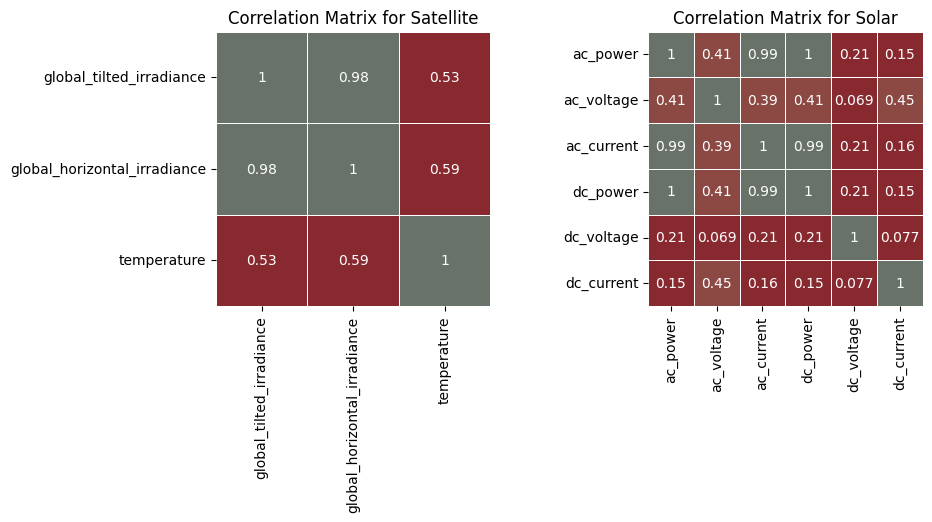

In [248]:
# Calculate the correlation matrix
my_colors = ['#88292F', '#8C4843', '#697268']
sns.set_palette(my_colors)

corr_matrix_dict = {}

for key, value in filtered_dfs_dict_solar.items():
    corr_matrix = value.corr()
    corr_matrix_dict[key] = corr_matrix

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 5))  # Adjust the size of the row

plot = 1
for key, corr in corr_matrix_dict.items():
    plt.subplot(1, 2, plot)  # One row, two columns
    sns.heatmap(corr, annot=True, cmap=my_colors, linewidths=0.5, square=True, cbar=False)  # Set square=True for equal aspect ratio
    plt.title(f'Correlation Matrix for {key}')
    plot += 1

plt.tight_layout()
plt.show()


makes sense to explore dc voltage vs dc current, because they have low correlation between them, so they give different knowledge. 

Doesn't make sense to explore dc variables against ac variables because dc gives information about the inverter (what actually matters) and ac about the grid.

# Outliers

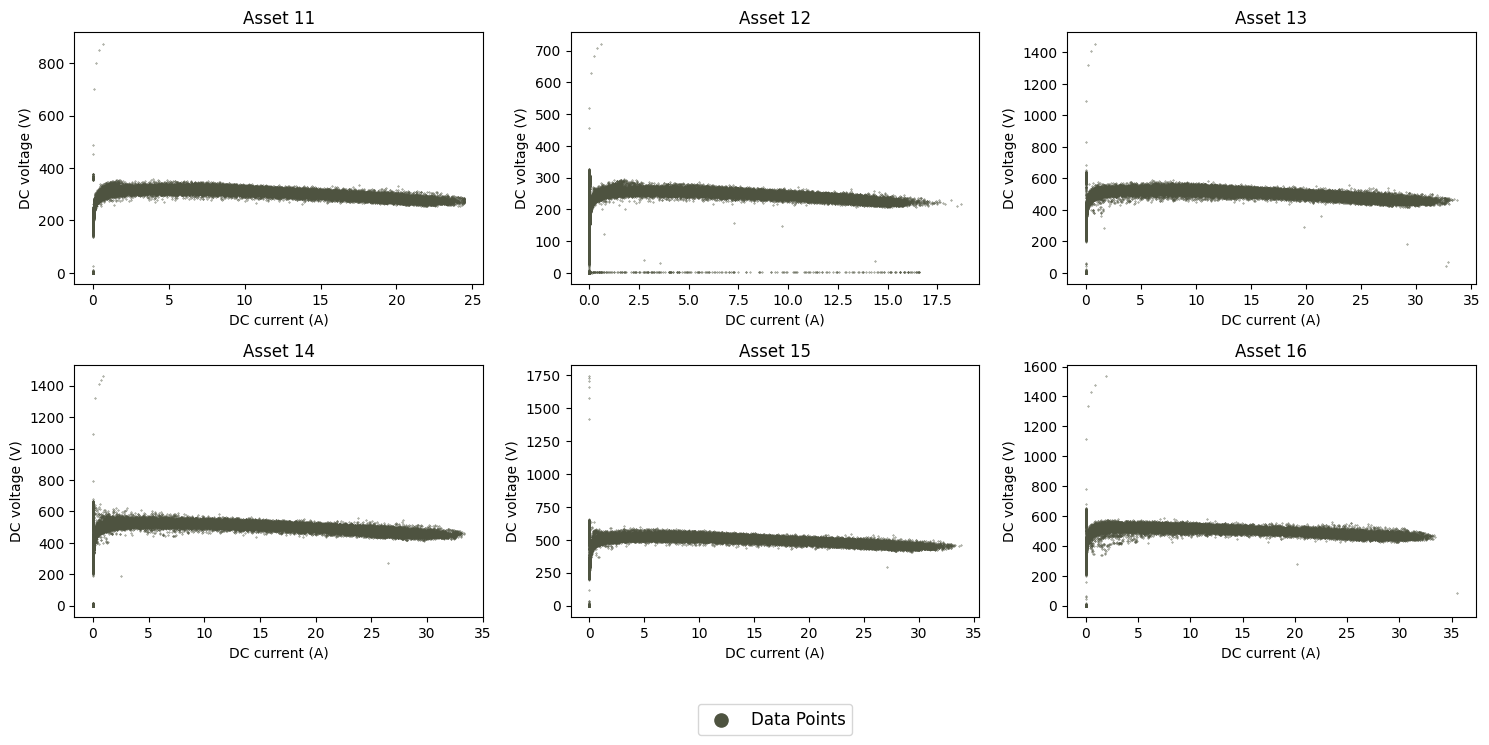

In [108]:
plot = 1
assets = df_solar["asset_id"].unique()[:6]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in df_solar[df_solar["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"Asset {asset}")
    plt.xlabel('DC current (A)')
    plt.ylabel('DC voltage (V)')
    plt.scatter(subset["dc_current"], subset["dc_voltage"], c="#4E5340", s=0.1)
    if plot == 5:
        # Add a single legend outside of the loop
        plt.legend(['Data Points'], loc='lower center', bbox_to_anchor=(0.5, -0.5), prop={'size': 12}, markerscale=30, ncol= 2)
    plot += 1


# Show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.show()

remove DC Power = 0:

In [109]:
df_solar = dfs_dict_solar['Solar']

In [110]:
df_solar_power_not_zero = df_solar[df_solar["dc_power"] > 0]

In [111]:
print(f'{percent_removed(df_solar, df_solar_power_not_zero)}%')

10.41%


In [112]:
df_solar = df_solar[df_solar["dc_power"] > 0]

try a "logical" way to identify and remove outliers:

In [113]:
np.sort(df_solar["asset_id"].unique())

array([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  51,  52,  53,
        54,  55,  56,  57,  58,  59, 110, 111, 112, 210, 211, 212, 213,
       214, 215, 216, 217, 310, 311, 312, 313, 314, 315, 316, 317, 410,
       411, 412, 413, 414, 415, 416, 417, 510, 511, 512, 513, 514])

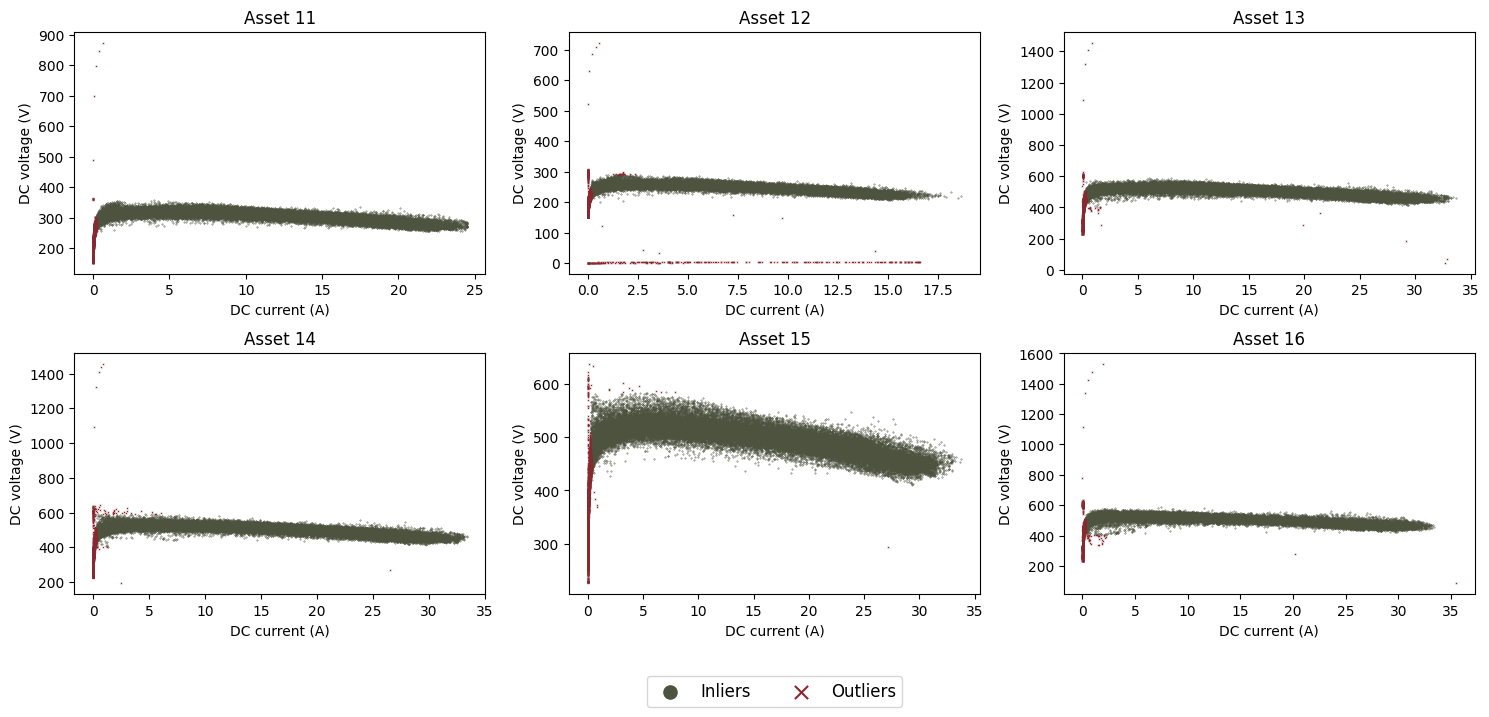

In [114]:
plot = 1
assets = np.sort(df_solar["asset_id"].unique())[:6]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in df_solar[df_solar["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"Asset {asset}")
    plt.xlabel('DC current (A)')
    plt.ylabel('DC voltage (V)')
    _subset = subset[(subset["dc_power"] > subset["dc_power"].max()*0.008) &
                     (subset["dc_voltage"] < (subset["dc_voltage"].median())*1.175) & 
                     (subset["dc_voltage"] > (subset["dc_voltage"].median())*0.80)]
    outliers = subset[~subset.index.isin(_subset.index)]
    plt.scatter(_subset["dc_current"], _subset["dc_voltage"], c="#4E5340", s=0.1)
    plt.scatter(outliers["dc_current"], outliers["dc_voltage"], c='#88292F', s=0.1, marker='x')    
    if plot == 5:
        plt.legend(['Inliers', 'Outliers'], loc='lower center', bbox_to_anchor=(0.5, -0.5), prop={'size': 12}, markerscale=30, ncol = 2)
    plot += 1


# Show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

remove this outs:

In [115]:
# Initialize an empty DataFrame to store the filtered data
solar_without_out_inter = pd.DataFrame()

# Group the DataFrame by "asset_id"
grouped = df_solar.groupby("asset_id")

# Iterate over each group
for asset_id, group_df in grouped:
    # Filter the data for the current asset
    filtered_data = group_df[['dc_current', 'dc_voltage']]

    median_dc_voltage = group_df["dc_voltage"].median()
    max_dc_power = group_df["dc_power"].max()

    # Apply the filtering conditions within each group, excluding outliers
    subset = group_df[(group_df["dc_power"] > group_df["dc_power"].max() * 0.008) &
                       (group_df["dc_voltage"] < median_dc_voltage * 1.175) & 
                       (group_df["dc_voltage"] > median_dc_voltage * 0.80)]

    # Concatenate the filtered subset to the overall filtered DataFrame
    solar_without_out_inter = pd.concat([solar_without_out_inter, subset])

In [116]:
print(f'{percent_removed(df_solar_power_not_zero,solar_without_out_inter)}%')

11.32%


test Mean-Squared Error:

In [122]:
# Create an empty list to store outliers for each asset
outliers_list = []

assets = np.sort(solar_without_out_inter["asset_id"].unique())[:6]

n_plots = 6

# Group the data by wind speed intervals
dc_current_intervals = pd.cut(solar_without_out_inter['dc_current'], bins=np.arange(0, solar_without_out_inter['dc_current'].max() + 0.1, 0.1))
grouped_df = solar_without_out_inter.groupby([dc_current_intervals, "asset_id"])

for (dc_current_interval, asset_id), group_df in grouped_df:
    # Calculate mean power and within-group mean square deviation
    mean_power = group_df['dc_voltage'].mean()
    n = len(group_df)
    mean_square_deviation = np.sqrt(((group_df['dc_voltage'] - mean_power) ** 2).sum() / (n - 1))
    
    # Select the mean square deviation multiplier
    mean_sq_dev_multiplier = 2
    
    # Threshold for identifying outliers
    threshold = mean_sq_dev_multiplier * mean_square_deviation 

    # Filter out outliers
    outliers = group_df[(group_df['dc_voltage'] - mean_power).abs() > threshold]

    # Append outliers for each asset to the outliers list
    outliers_list.append(outliers)

# Plot the data points with outliers in a different color
inliers_df = solar_without_out_inter.drop(pd.concat(outliers_list).index)

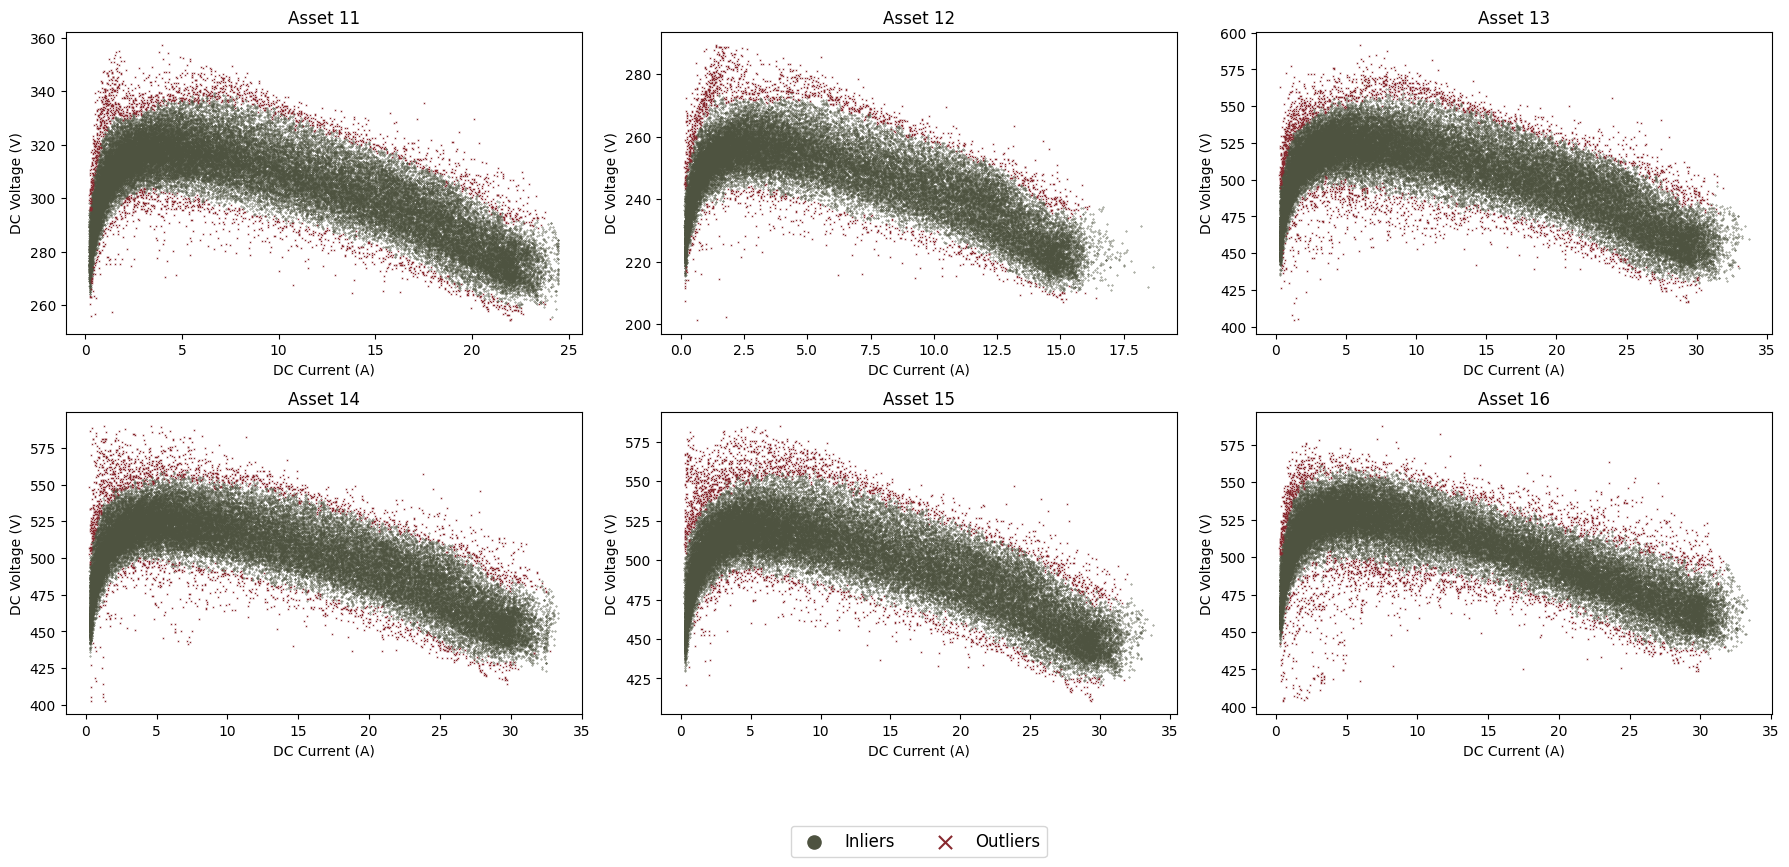

In [123]:
plt.figure(figsize=(n_plots*3, n_plots*1.5))

# Create subplots for assets
for i, asset_id in enumerate(assets, 1):
    plt.subplot(2, 3, i)

    asset_inliers = inliers_df[inliers_df["asset_id"] == asset_id]
    asset_outliers = pd.concat([outliers[outliers["asset_id"] == asset_id] for outliers in outliers_list])

    plt.scatter(asset_inliers["dc_current"], asset_inliers["dc_voltage"], c="#4E5340", s=0.1)
    plt.scatter(asset_outliers["dc_current"], asset_outliers["dc_voltage"], c="#88292F", s=0.1, marker="x")

    plt.title(f'Asset {asset_id}')
    plt.xlabel('DC Current (A)')
    plt.ylabel('DC Voltage (V)')

    if i == 5:
        # Add a single legend outside of the loop
        plt.legend(['Inliers', 'Outliers'], loc='lower center', bbox_to_anchor=(0.5, -0.5), prop={'size': 12}, markerscale=30, ncol= 2)


# Show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()


test the DBSCAN method to identify outliers:

Number of outliers for Asset 11: 1015
Number of outliers for Asset 12: 546
Number of outliers for Asset 13: 3010
Number of outliers for Asset 14: 3027
Number of outliers for Asset 15: 3099
Number of outliers for Asset 16: 2914


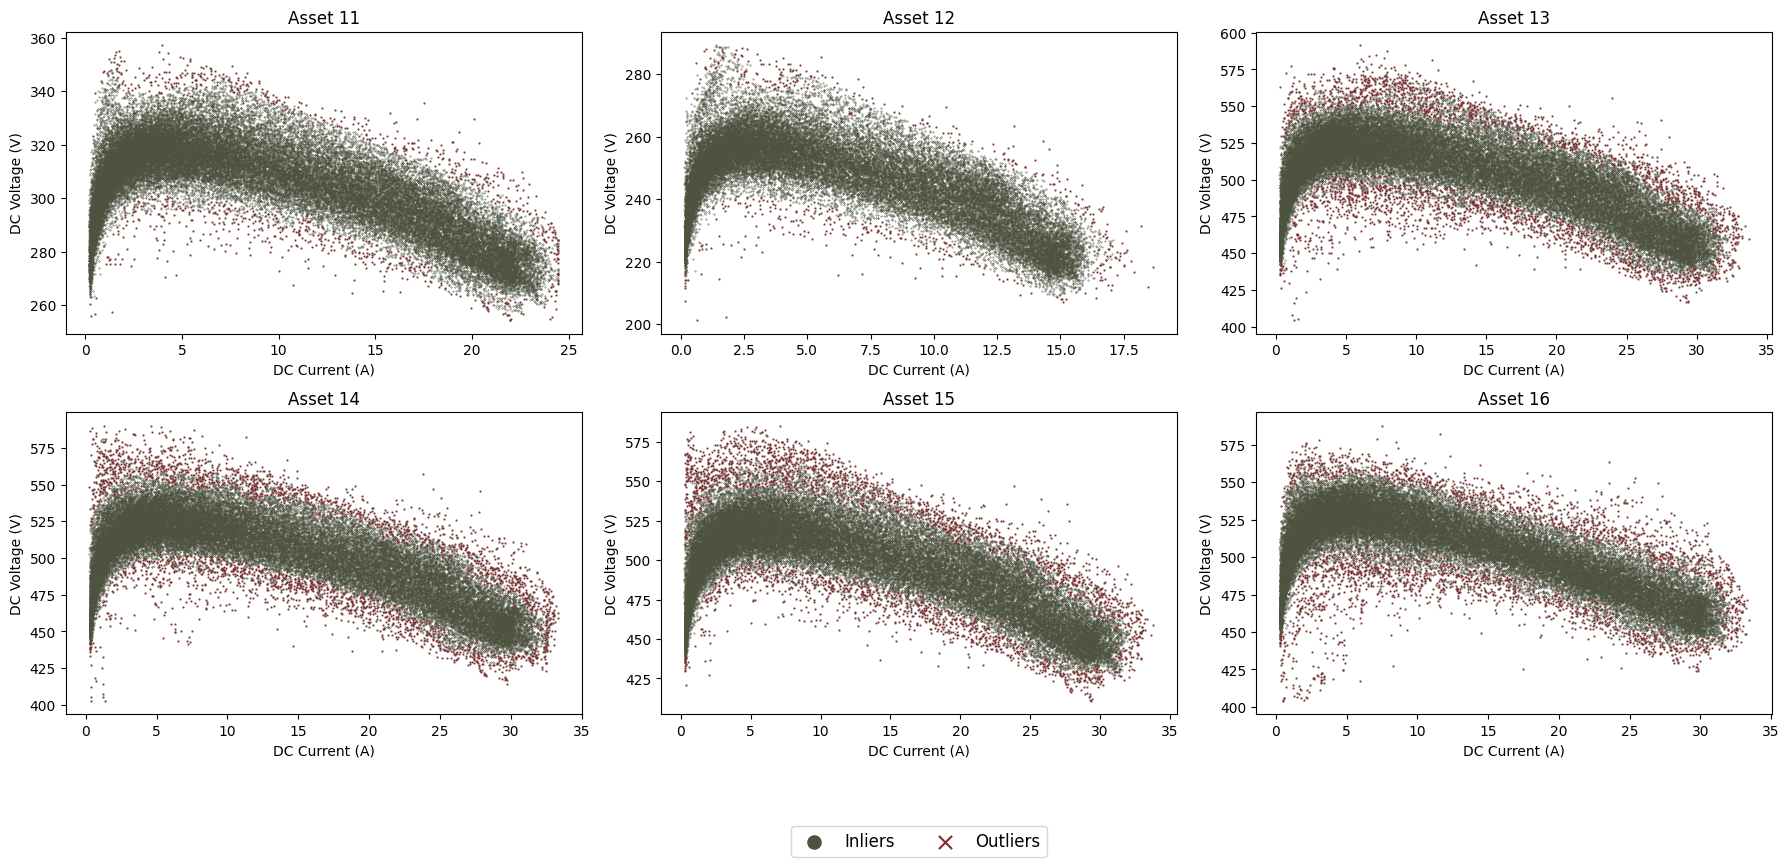

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Define the DBSCAN parameters
eps = 0.4
min_samples = 5

# Define the number of plots
n_plots = 6

# Create a figure with appropriate size
plt.figure(figsize=(n_plots*3, n_plots*1.5))

# Iterate over the first 6 assets
for plot, asset_id in enumerate(solar_without_out_inter['asset_id'].unique()[:n_plots], start=1):
    # Filter the data for the current asset
    filtered_data = solar_without_out_inter[solar_without_out_inter['asset_id'] == asset_id][['dc_current', 'dc_voltage']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    # Create a subplot
    plt.subplot(2, 3, plot)
    
    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['dc_current'], filtered_data['dc_voltage'], c='#4E5340', s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#88292F", marker="x", s=0.1)
    
    # Set title and labels
    plt.title(f'Asset {asset_id}')
    plt.xlabel('DC Current (A)')
    plt.ylabel('DC Voltage (V)')

    if plot == 5:
        plt.legend(["Inliers", 'Outliers'], loc='lower center', bbox_to_anchor=(0.5, -0.5), prop={'size': 12}, markerscale=30, ncol = 2)

# Show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

test the robust covariance method to identify the outliers:

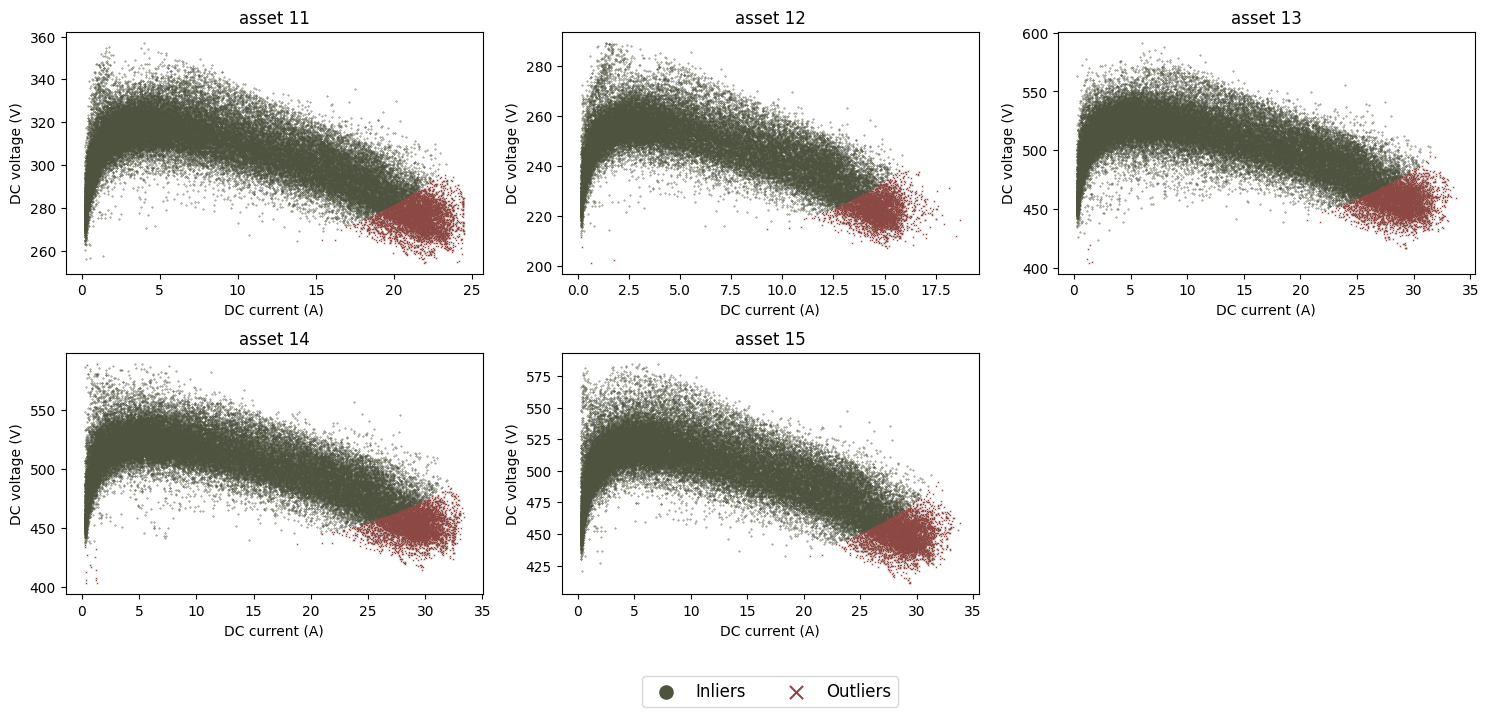

In [261]:
plot = 1
assets = solar_without_out_inter["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in solar_without_out_inter[solar_without_out_inter["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC current (A)')
    plt.ylabel('DC voltage (V)')
    
    # Fit the Elliptic Envelope
    robust_cov = EllipticEnvelope().fit(subset[["dc_current", "dc_voltage"]])
    
    # Detect outliers using the robust covariance
    outliers = robust_cov.predict(subset[["dc_current", "dc_voltage"]]) == -1
    
    # Filter the subset to exclude outliers
    _subset = subset[~outliers]
    outliers_df = subset[outliers]
    
    plt.scatter(_subset["dc_current"], _subset["dc_voltage"], c="#4E5340", s=0.1)
    plt.scatter(outliers_df["dc_current"], outliers_df["dc_voltage"], c="#8C4843", s=0.1, marker='x')
    plot += 1

plt.legend(["Inliers", 'Outliers'], loc='lower center', bbox_to_anchor=(0.5, -0.5), prop={'size': 12}, markerscale=30, ncol = 2)

# Show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

The robust covariance method cuts out data points that should not be considered as outliers, and took 1min and 12 secs to run just 5 assets

Filter the solar df to exclude the outliers by applying the Mean-Square Error to the entire df

In [262]:
final_df_solar = pd.DataFrame()

outliers_list = []

assets = solar_without_out_inter["asset_id"].unique()

# Group the data by wind speed intervals
dc_current_intervals = pd.cut(solar_without_out_inter['dc_current'], bins=np.arange(0, solar_without_out_inter['dc_current'].max() + 0.1, 0.1))
grouped_df = solar_without_out_inter.groupby([dc_current_intervals, "asset_id"])

for (dc_current_interval, asset_id), group_df in grouped_df:
    # Calculate mean power and within-group mean square deviation
    mean_power = group_df['dc_voltage'].mean()
    n = len(group_df)
    mean_square_deviation = np.sqrt(((group_df['dc_voltage'] - mean_power) ** 2).sum() / (n - 1))
    
    # Select the mean square deviation multiplier
    mean_sq_dev_multiplier = 2
    
    # Threshold for identifying outliers
    threshold = mean_sq_dev_multiplier * mean_square_deviation 

    # Filter out outliers
    outliers = group_df[(group_df['dc_voltage'] - mean_power).abs() > threshold]

    # Append outliers for each asset to the outliers list
    outliers_list.append(outliers)

# Plot the data points with outliers in a different color
final_df_solar = solar_without_out_inter.drop(pd.concat(outliers_list).index)

final_df_solar.to_csv('intermediate/solar/cleaned_df_solar.csv', index=False)

Confirm that the df was cleaned:

In [127]:
final_df_solar = pd.read_csv('intermediate/solar/cleaned_df_solar.csv')

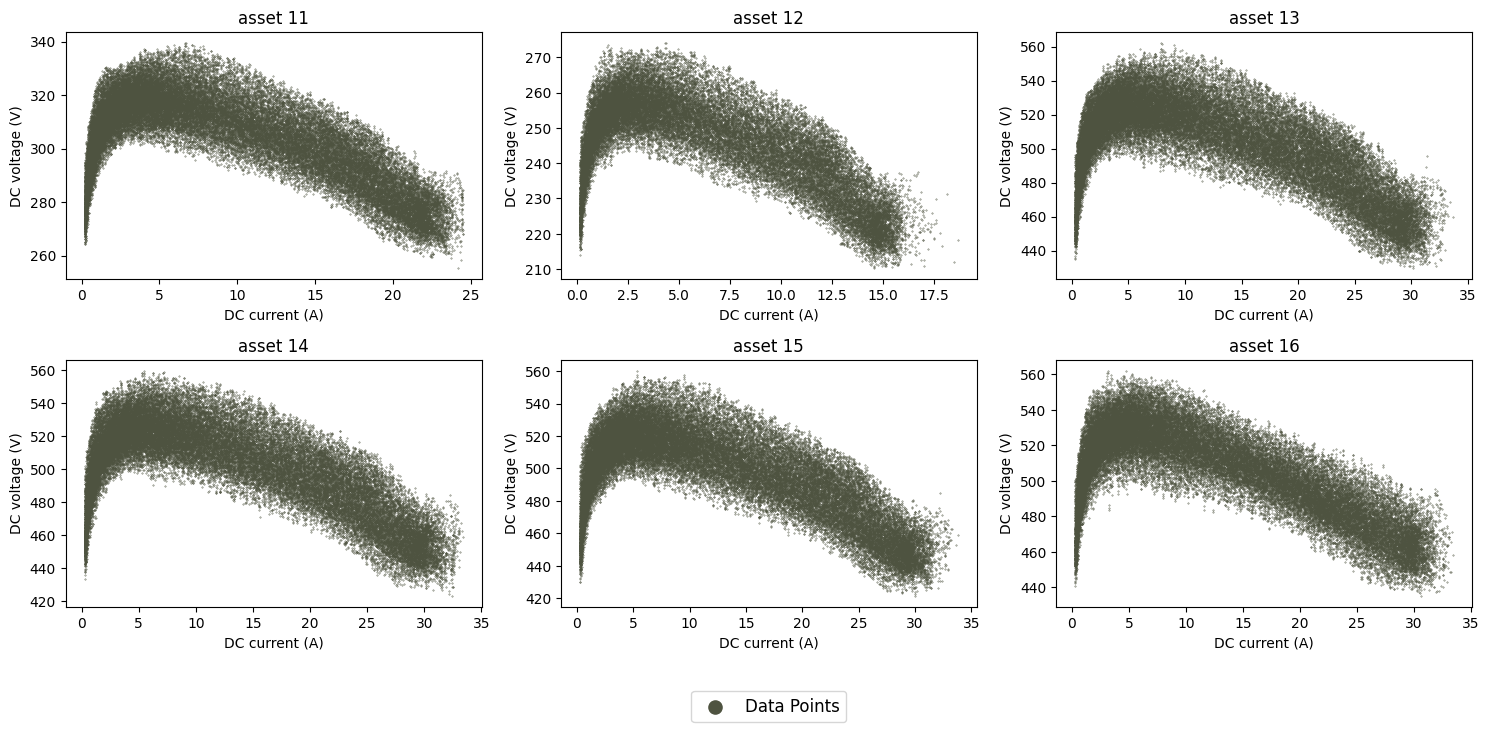

In [129]:
plot = 1
assets = final_df_solar["asset_id"].unique()[:6]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in final_df_solar[final_df_solar["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC current (A)')
    plt.ylabel('DC voltage (V)')
    plt.scatter(subset["dc_current"], subset["dc_voltage"], c="#4E5340", s=0.1)
    if plot == 5:
        # Add a single legend outside of the loop
        plt.legend(['Data Points'], loc='lower center', bbox_to_anchor=(0.5, -0.5), prop={'size': 12}, markerscale=30, ncol= 2)
    plot += 1
plt.tight_layout()
plt.show()

In [264]:
percent_outliers = percent_removed(df_solar, final_df_solar)
print(f'{percent_outliers}%')

16.99%


In [35]:
assets = final_df_solar["asset_id"].unique()
n_plots_per_file = 6
n_assets = len(assets)
n_files = (n_assets - 1) // n_plots_per_file + 1

# Create the output directory if it doesn't exist
output_dir = "intermediate/solar/plots"
os.makedirs(output_dir, exist_ok=True)

# Iterate over each batch of assets
for file_idx in range(n_files):
    start_idx = file_idx * n_plots_per_file
    end_idx = min((file_idx + 1) * n_plots_per_file, n_assets)
    assets_batch = assets[start_idx:end_idx]

    # Plot and save the graphs for the current batch of assets
    plot = 1
    plt.figure(figsize=(n_plots_per_file * 3, n_plots_per_file * 1.5))
    for asset in assets_batch:
        subset = final_df_solar[final_df_solar["asset_id"] == asset]
        plt.subplot(2, 3, plot)
        plt.title(f"asset {asset}")
        plt.xlabel('DC Current (A)')
        plt.ylabel('DC Voltage (V)')
        plt.scatter(subset["dc_current"], subset["dc_voltage"], c="#4E5340", s=0.1)
        plot += 1
    plt.tight_layout()

    # Save the plot to a file
    filename = f'plots_{start_idx + 1}_{end_idx}.png'
    plt.savefig(os.path.join(output_dir, filename))

    # Close the current plot
    plt.close()

# Satellite + Solar

In [266]:
with open("intermediate/solar/dfs_dict_solar.pickle", "rb") as f:
    dfs_dict_solar = pickle.load(f)

In [30]:
final_df_solar = pd.read_csv('intermediate/solar/cleaned_df_solar.csv')

In [32]:
# Merge cleaned df_solar and df_satellite

df_satellite_copy = dfs_dict_solar["Satellite"]

df_satellite_copy.rename(columns={'satellite_id': 'farm'}, inplace=True)


In [36]:
merged_df = final_df_solar.merge(df_satellite_copy, on=["read_at", "farm"], how="inner")

merged_df.head()

asset_id              read_at  ac_power  ac_voltage  ac_current  dc_power  \
0        11  2022-01-01 08:10:00      82.0       235.0       0.298   60.6247   
1        13  2022-01-01 08:10:00     124.0       235.0       0.450  134.7940   
2        14  2022-01-01 08:10:00     269.0       235.0       0.696  280.0100   
3        15  2022-01-01 08:10:00     195.0       235.0       0.549  201.4470   
4        17  2022-01-01 08:10:00     224.0       234.0       0.616  232.5800   

   dc_voltage  dc_current  farm  global_tilted_irradiance  \
0     275.567       0.220     1                       2.0   
1     469.667       0.287     1                       2.0   
2     510.967       0.548     1                       2.0   
3     491.333       0.410     1                       2.0   
4     483.533       0.481     1                       2.0   

   global_horizontal_irradiance  temperature  cloud_cover  
0                           2.0         12.3         46.1  
1                           2.0         12.3         46.1  
2                           2.0         12.3         46.1  
3                           2.0         12.3         46.1  
4                           2.0         12.3         46.1

In [38]:
merged_df[['asset_id', 'read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature' , 'cloud_cover', 'farm']].to_csv("intermediate/solar/solar_satellite_merged_clean.csv", index=False)

In [39]:
merged_df = merged_df.drop(columns=['ac_power', 'ac_voltage', 'ac_current', 'farm'])

In [40]:
merged_df.head()

asset_id              read_at  dc_power  dc_voltage  dc_current  \
0        11  2022-01-01 08:10:00   60.6247     275.567       0.220   
1        13  2022-01-01 08:10:00  134.7940     469.667       0.287   
2        14  2022-01-01 08:10:00  280.0100     510.967       0.548   
3        15  2022-01-01 08:10:00  201.4470     491.333       0.410   
4        17  2022-01-01 08:10:00  232.5800     483.533       0.481   

   global_tilted_irradiance  global_horizontal_irradiance  temperature  \
0                       2.0                           2.0         12.3   
1                       2.0                           2.0         12.3   
2                       2.0                           2.0         12.3   
3                       2.0                           2.0         12.3   
4                       2.0                           2.0         12.3   

   cloud_cover  
0         46.1  
1         46.1  
2         46.1  
3         46.1  
4         46.1

In [ ]:
len(merged_df)

2726406

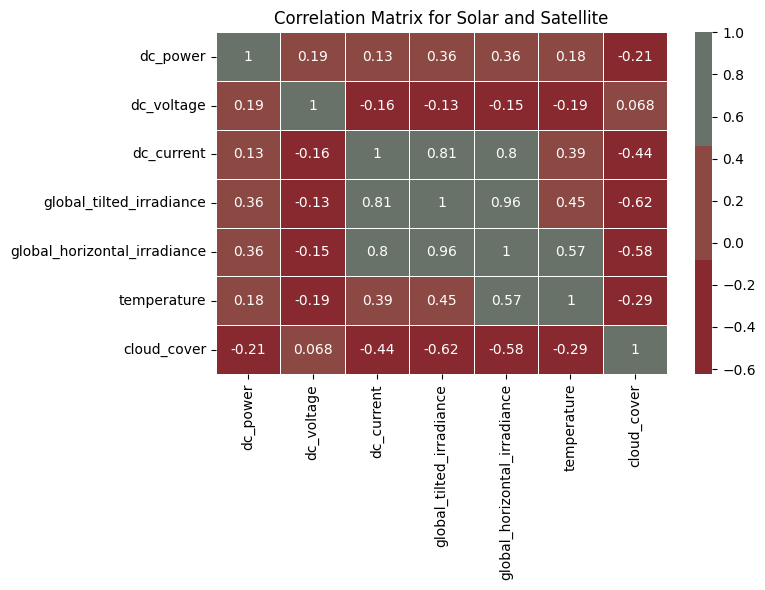

In [ ]:
# Calculate the correlation matrix
my_colors = ['#88292F', '#8C4843', '#697268']
sns.set_palette(my_colors)


corr_matrix = merged_df.loc[:,'dc_power':].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap=my_colors, linewidths=0.5)
plt.title(f'Correlation Matrix for Solar and Satellite')
plt.tight_layout()
plt.show()

considerering a thershold of 80%, ie, variables with more than 80% correlation with others are removed

so, the variables to include for the model should be dc_power, dc_voltage, dc_current, temperature and cloud_cover, as global_tilted_irradiance and global_horizontal_irradiance have very high correlation with other variables and keeping them, would be reductant

# IGNORE HERE ONWARD

## Outliers

this was done in an early phase of the project, but now, since the irradiance variable was not used for the model, i dont think it make sense treat the outliers that result from the irradiance variable

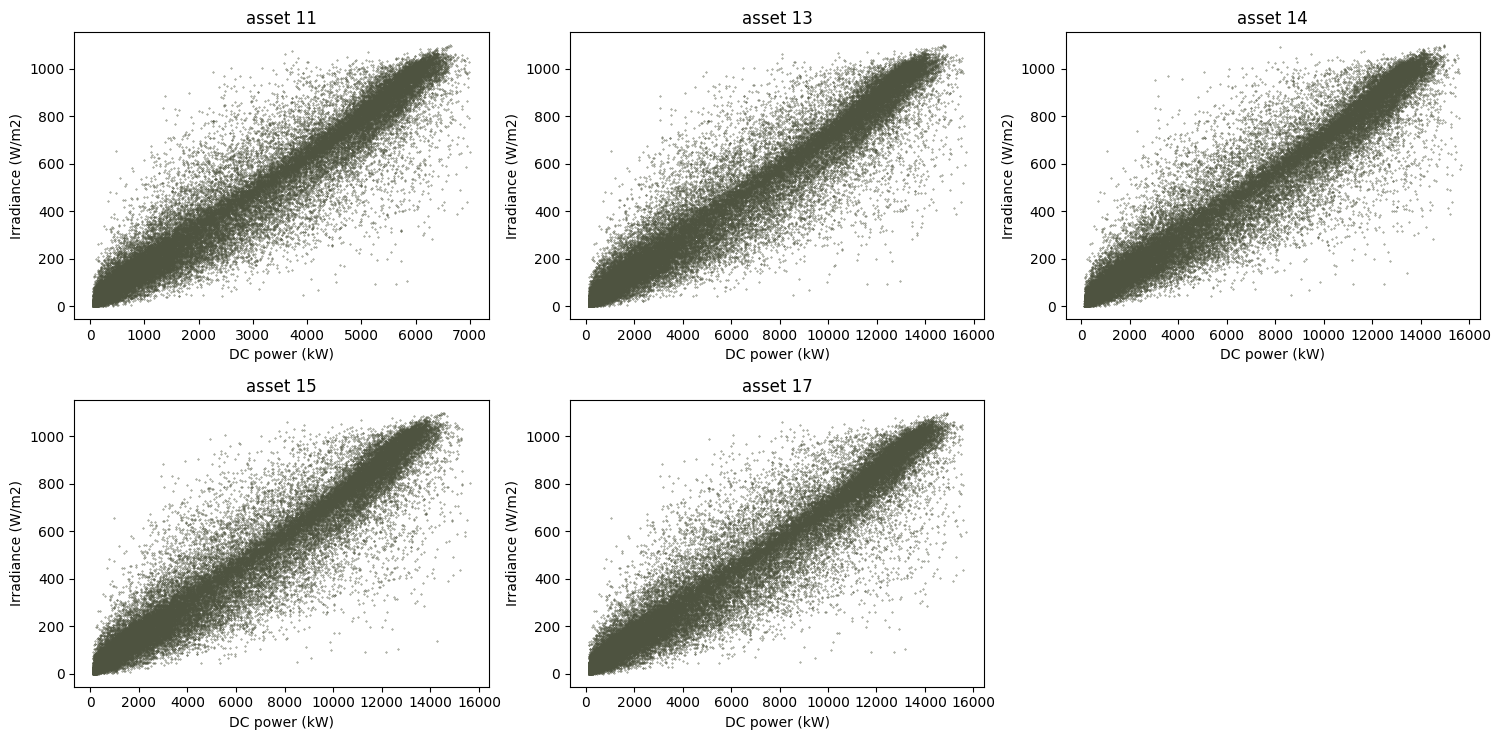

In [ ]:
assets = merged_df["asset_id"].unique()[:5]

grouped_assets_solar_satellite = merged_df[merged_df["asset_id"].isin(assets)].groupby("asset_id")

plot = 1
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in grouped_assets_solar_satellite:
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC power (kW)')
    plt.ylabel('Irradiance (W/m2)')
    plt.scatter(subset["dc_power"], subset["global_tilted_irradiance"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

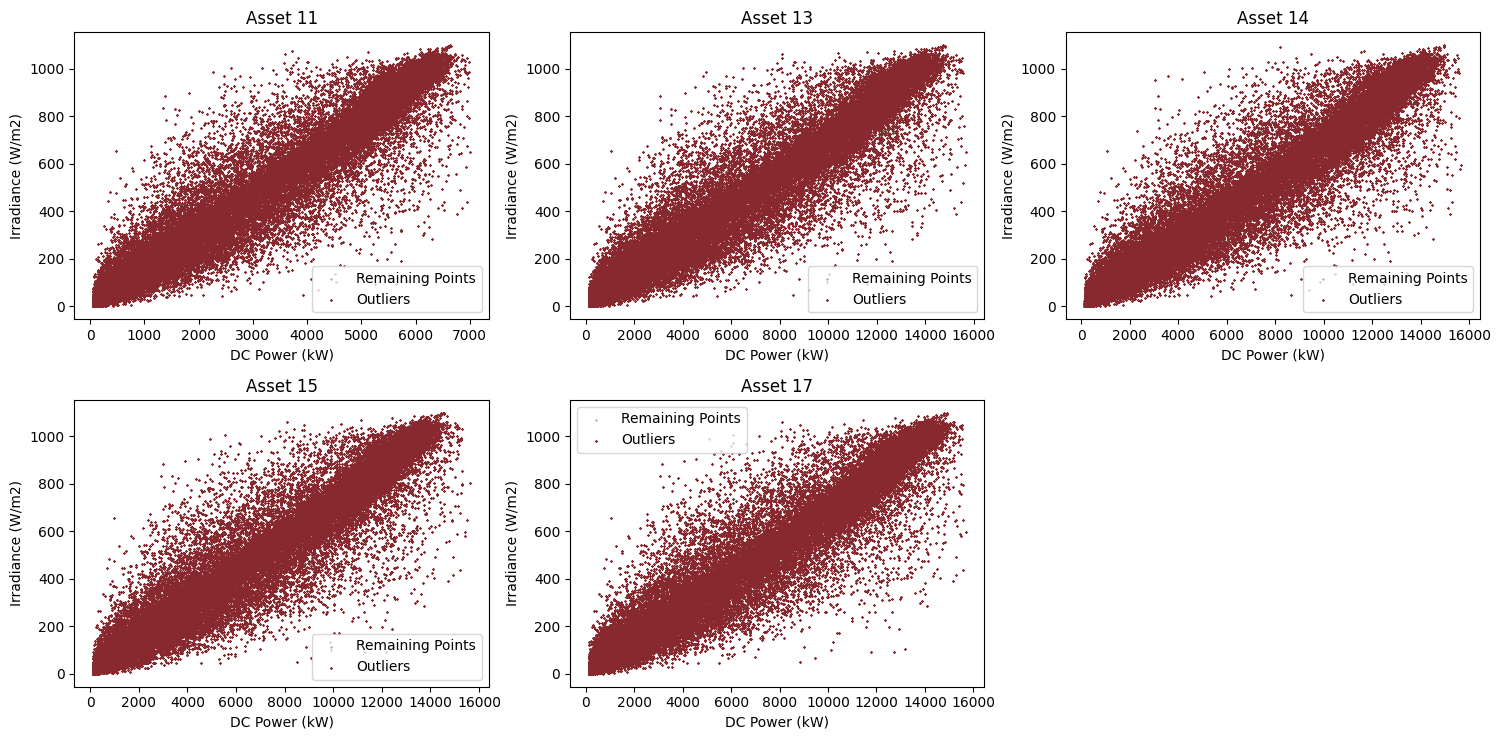

In [ ]:
# Define the DBSCAN parameters
eps = 0.3
min_samples = 5

n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))

# Iterate over the first 5 assets
for i, asset_id in enumerate(assets, 1):
    # Filter the data for the current asset
    filtered_data = merged_df[merged_df['asset_id'] == asset_id][['dc_power', 'global_tilted_irradiance']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Plot the scatter plot
    plt.subplot(2, 3, i)
    plt.title(f'Asset {asset_id}')
    plt.xlabel('DC Power (kW)')
    plt.ylabel('Irradiance (W/m2)')

    # Plotting the remaining points
    plt.scatter(filtered_data['dc_power'], filtered_data['global_tilted_irradiance'], c='#4E5340', s=0.1, label="Remaining Points")
    
    # Plotting the outliers
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c='#88292F', marker="x", s=1, label="Outliers")
    
    plt.legend()

plt.tight_layout()
plt.show()



test Robust Covariance:

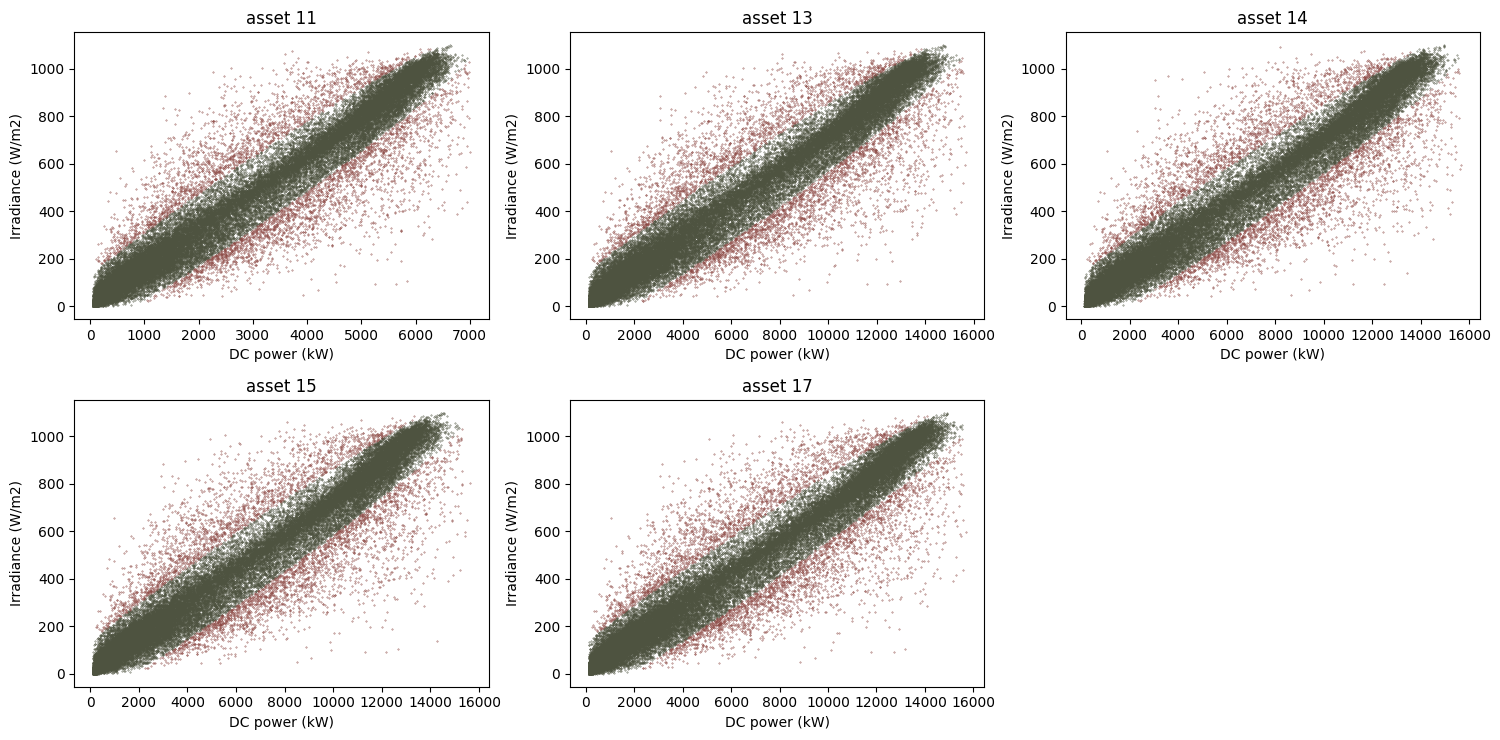

In [ ]:
plot = 1
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in grouped_assets_solar_satellite:
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC power (kW)')
    plt.ylabel('Irradiance (W/m2)')
    
    # Fit the Elliptic Envelope
    robust_cov = EllipticEnvelope().fit(subset[["dc_power", "global_tilted_irradiance"]])
    
    # Detect outliers using the robust covariance
    outliers = robust_cov.predict(subset[["dc_power", "global_tilted_irradiance"]]) == -1
    
    # Filter the subset to exclude outliers
    asset_inliers = subset[~outliers]
    asset_outliers = subset[outliers]
    
    plt.scatter(asset_inliers["dc_power"], asset_inliers["global_tilted_irradiance"], c="#4E5340", s=0.1)
    plt.scatter(asset_outliers["dc_power"], asset_outliers["global_tilted_irradiance"], c="#8C4843", s=0.1)

    plot += 1

plt.tight_layout()
plt.show()

### Apply robust covariance to the dataset

In [ ]:
# Initialize an empty DataFrame to store the filtered data

df_solar_satellite = pd.DataFrame()

# Group the DataFrame by "asset_id"
grouped = merged_df.groupby("asset_id")

# Define robust covariance parameters
contamination = 0.05  # Expected fraction of outliers

# Iterate over each group
for asset_id, group_df in grouped:
    # Fit the Elliptic Envelope
    robust_cov = EllipticEnvelope(contamination=contamination).fit(group_df[["dc_power", "global_tilted_irradiance"]])
    
    # Detect outliers using the robust covariance
    outliers = robust_cov.predict(group_df[["dc_power", "global_tilted_irradiance"]]) == -1
    
    # Apply the filtering conditions within each group, excluding outliers
    subset = group_df[~outliers]
    
    # Concatenate the filtered subset to the overall filtered DataFrame
    df_solar_satellite = pd.concat([df_solar_satellite, subset])


In [ ]:
df_solar_satellite = df_solar_satellite.reset_index(drop=True)
df_solar_satellite.head()

asset_id              read_at  dc_power  dc_voltage  dc_current  \
0        11  2022-01-01 08:10:00   60.6247     275.567       0.220   
1        11  2022-01-01 08:20:00  157.1340     301.600       0.521   
2        11  2022-01-01 08:30:00  297.7330     313.733       0.949   
3        11  2022-01-01 08:40:00  645.5820     323.600       1.995   
4        11  2022-01-01 08:50:00  617.0240     321.367       1.920   

   global_tilted_irradiance  global_horizontal_irradiance  temperature  \
0                       2.0                           2.0         12.3   
1                       9.0                           9.0         12.4   
2                      52.0                          29.0         12.6   
3                     126.0                          55.0         12.7   
4                     235.0                          83.0         12.9   

   cloud_cover  
0         46.1  
1         56.1  
2         37.2  
3         12.5  
4          3.0

In [ ]:
df_solar_satellite.to_csv("intermediate/solar/df_solar_satellite.csv", index=False)

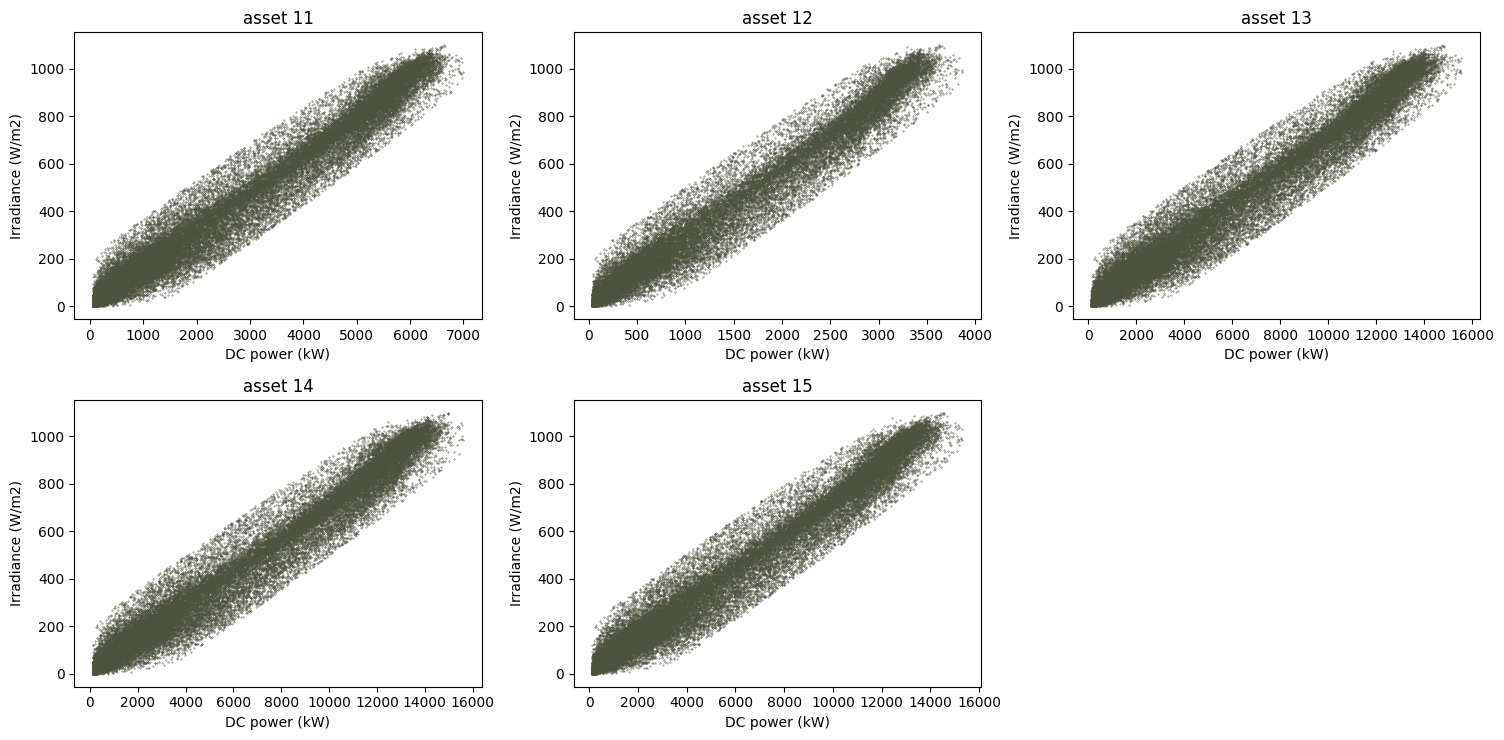

In [ ]:
# Plotting
plot = 1
n_plots = 5
assets = df_solar_satellite["asset_id"].unique()[:5]
grouped_solar_satellite = df_solar_satellite[df_solar_satellite["asset_id"].isin(assets)]
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in grouped_solar_satellite.groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC power (kW)')
    plt.ylabel('Irradiance (W/m2)')
    plt.scatter(subset["dc_power"], subset["global_tilted_irradiance"], c="#4E5340", s=0.1)
    plot += 1

plt.tight_layout()
plt.show()

In [ ]:
df_solar_satellite = pd.read_csv('intermediate/solar/df_solar_satellite.csv')
solar_satellite_original = pd.read_csv('intermediate/solar/solar_satellite_merged.csv')

In [ ]:
percent_removed = ((len(solar_satellite_original)/len(df_solar_satellite))-1)*100

print(f"{len(solar_satellite_original)-len(df_solar_satellite)} were considered outliers and deleted")
print(f'Which represents {round(percent_removed,2)}% of the data set')

136352 were considered outliers and deleted
Which represents 5.26% of the data set
